In [283]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("Paired")

In [284]:
df = pd.read_csv('serbyli_all_variables_MEAN.csv',
    usecols=('date', #'kaupverd', 'fasteignamat', 
    'byggar', 'einflm', 'lod_flm','verd_m2',
     #  'fjöldi_kaupsamninga', 'auglyst_serbyli', 'solutimi', 'Verðtryggð lán',
      # 'erlend_lan', 'Óverðtryggð lán', 'overdtryggt', 'verdtryggt',
       #'visitala_rvk_%', 'verdbolga_%')
    )
    indep = pd.read_csv('20_independent_variables_LSTM.csv', parse_dates=True)

In [285]:
df.columns

Index(['date', 'byggar', 'einflm', 'lod_flm', 'verd_m2', 'fjöldi_kaupsamninga',
       'auglyst_serbyli', 'solutimi', 'Verðtryggð lán', 'erlend_lan',
       'Óverðtryggð lán', 'overdtryggt', 'verdtryggt', 'visitala_rvk_%',
       'verdbolga_%'],
      dtype='object')

In [286]:
fm2 = df['verd_m2']
df.drop('verd_m2', axis=1, inplace=True)
df.insert(1, 'verd_m2', fm2)
df.tail()

,date,verd_m2,byggar,einflm,lod_flm,fjöldi_kaupsamninga,auglyst_serbyli,solutimi,Verðtryggð lán,erlend_lan,Óverðtryggð lán,overdtryggt,verdtryggt,visitala_rvk_%,verdbolga_%
188,2022-01-01,522.140885,1980.486842,193.510526,1551.919737,598.23,0.12,0.79,40.28,0.07,40.45,3.95,1.50,1.7,0.161253
189,2022-02-01,529.559932,1978.320000,202.034000,1117.332000,516.03,0.13,0.88,40.28,0.07,40.45,4.15,1.50,2.5,1.264949
190,2022-03-01,590.712389,1979.960784,185.774510,1191.400000,516.03,0.12,0.88,40.28,0.07,40.45,4.15,1.50,3.1,0.817624
191,2022-04-01,585.286590,1982.400000,180.857778,1037.535556,516.03,0.12,0.88,40.28,0.07,40.45,4.15,1.49,2.7,0.991214
192,2022-05-01,569.803711,1979.475000,190.230000,1498.110000,516.03,0.12,0.88,40.28,0.07,40.45,4.65,1.49,2.7,0.423823


In [287]:
df.shape

(193, 15)

In [288]:
train_dates = pd.to_datetime(df['date'])
print(train_dates.tail(4))

189   2022-02-01
190   2022-03-01
191   2022-04-01
192   2022-05-01
Name: date, dtype: datetime64[ns]


In [289]:
#Variables for training
cols = list(df)[1:]
#Date is not used in training. 
print(cols)

['verd_m2', 'byggar', 'einflm', 'lod_flm', 'fjöldi_kaupsamninga', 'auglyst_serbyli', 'solutimi', 'Verðtryggð lán', 'erlend_lan', 'Óverðtryggð lán', 'overdtryggt', 'verdtryggt', 'visitala_rvk_%', 'verdbolga_%']


In [290]:
df_for_training = df[cols].astype(float)

In [291]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [292]:
trainX = []
trainY = []

n_future = 2   # Number of months we want to look into the future based on the past months.
n_past = 2  # Number of past months we want to use to predict the future.

In [293]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (190, 2, 14).
trainY shape == (190, 1).


In [294]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 2, 64)             20224     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 32,673
Trainable params: 32,673
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
6/6 [==============================] - 3s 85ms/step - loss: 0.5497 - val_loss: 4.6890
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4875 - val_loss: 4.5423
Epoch 3/100
6/6 [==============================] - 0s 14ms/step - loss: 0.4134 - val_loss: 4.3262
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 0.3491 - val_loss: 3.9829
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.2945 - val_loss: 3.4149
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 0.2520 - val_loss: 2.5061
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.1808 - val_loss: 1.3106
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1225 - val_loss: 0.2762
Epoch 9/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0879 - val_loss: 0.6632
Epoch 10/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0722 - val_loss: 0.3244
Epoch 11/100
6/6 [==

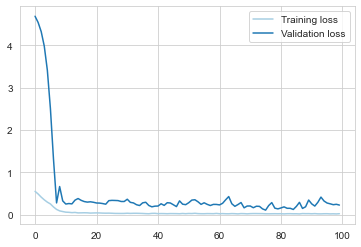

In [295]:
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [296]:
n_past = 170
n_days_for_prediction=173  #4 months

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='m').tolist()
print(predict_period_dates)

[Timestamp('2008-04-30 00:00:00', freq='M'), Timestamp('2008-05-31 00:00:00', freq='M'), Timestamp('2008-06-30 00:00:00', freq='M'), Timestamp('2008-07-31 00:00:00', freq='M'), Timestamp('2008-08-31 00:00:00', freq='M'), Timestamp('2008-09-30 00:00:00', freq='M'), Timestamp('2008-10-31 00:00:00', freq='M'), Timestamp('2008-11-30 00:00:00', freq='M'), Timestamp('2008-12-31 00:00:00', freq='M'), Timestamp('2009-01-31 00:00:00', freq='M'), Timestamp('2009-02-28 00:00:00', freq='M'), Timestamp('2009-03-31 00:00:00', freq='M'), Timestamp('2009-04-30 00:00:00', freq='M'), Timestamp('2009-05-31 00:00:00', freq='M'), Timestamp('2009-06-30 00:00:00', freq='M'), Timestamp('2009-07-31 00:00:00', freq='M'), Timestamp('2009-08-31 00:00:00', freq='M'), Timestamp('2009-09-30 00:00:00', freq='M'), Timestamp('2009-10-31 00:00:00', freq='M'), Timestamp('2009-11-30 00:00:00', freq='M'), Timestamp('2009-12-31 00:00:00', freq='M'), Timestamp('2010-01-31 00:00:00', freq='M'), Timestamp('2010-02-28 00:00:00'

In [297]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

6/6 [==============================] - 0s 2ms/step


In [298]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [299]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'verd_m2':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

C:\Users\halld\AppData\Local\Temp\ipykernel_11888\279094052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])
c:\Anaconda\envs\Deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Anaconda\envs\Deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit key

<AxesSubplot:xlabel='date', ylabel='verd_m2'>

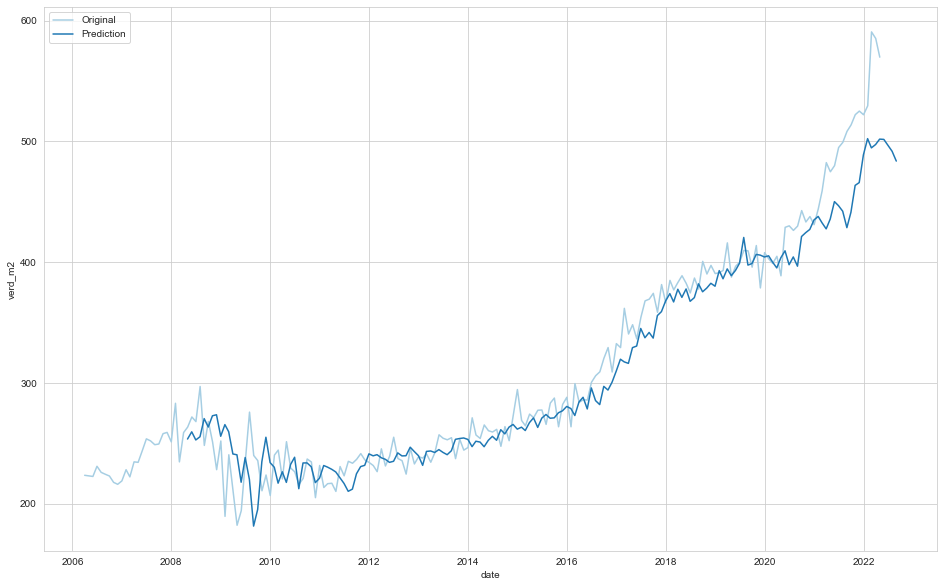

In [300]:
original = df[['date', 'verd_m2']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2006-1-1']

plt.figure(figsize=(16,10))
sns.lineplot(original['date'], original['verd_m2'], label='Original')
sns.lineplot(df_forecast['date'], df_forecast['verd_m2'], label='Prediction')